### Load packages and set options

In [1]:
# List of required packages
pkgs <- c('fBasics', 'corrplot', 'psych', 'glmnet', 'glmnetUtils', 'rpart',
          'rpart.plot', 'treeClust', 'randomForest', 'rlang', 'readr', 'devtools',
          'tidyverse')
# Load packages (install if needed)
for(pkg in pkgs){
    if(!(pkg %in% rownames(installed.packages()))){
        install.packages(pkg)
    }
    library(pkg, character.only = TRUE)
}
print('All packages successfully installed and loaded.')

# Set some initial variables and options
min_tree = 1
num_trees = 1000
set.seed(1001)

Loading required package: timeDate
Loading required package: timeSeries
corrplot 0.84 loaded

Attaching package: ‘psych’

The following object is masked from ‘package:fBasics’:

    tr

The following object is masked from ‘package:timeSeries’:

    outlier

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16


Attaching package: ‘glmnetUtils’

The following objects are masked from ‘package:glmnet’:

    cv.glmnet, glmnet

Loading required package: cluster
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:psych’:

    outlier

The following object is masked from ‘package:timeSeries’:

    outlier

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ ggplot2 3.1.0     ✔ forcats 0.3.0
── Conflicts ──────────────────

[1] "All packages successfully installed and loaded."


### Load dataset

In [2]:
# Load data
data_raw <- read.csv("used_cars.csv",header=TRUE, sep=",")

# These are the covariates we'll use
outcomes <- c("first_price", "final_price", "overprice")
baseline_covariates_bin <- c("bmw_320", "opel_astra", "mercedes_c", "vw_golf", "vw_passat", 
                          "diesel",   "private_seller", "guarantee", "maintenance_cert",  "pm_green")
baseline_covariates_cont <- c("mileage", "age_car_years", "other_car_owner", "inspection",
                              "co2_em", "euro_norm")
baseline_covariates <- c(baseline_covariates_cont,baseline_covariates_bin)
lasso_covariates_bin <- c("mile_20", "mile_30", "mile_40", "mile_50", "mile_100", "mile_150", 
                       "age_3", "age_6", "dur_next_ins_1_2", "new_inspection")  
lasso_covariates_cont <- c("mileage2", "mileage3", "mileage4", "age_car_years2", "age_car_years3",
                           "age_car_years4")  
lasso_covariates <- c(lasso_covariates_cont, lasso_covariates_bin)  
all_covariates <- c(baseline_covariates, lasso_covariates)
all_variables <- c(outcomes, all_covariates)

# Here you can select the number of Observation, max. 130,970
n_obs <- 10000

# Selecting only desired covariates
df <- data_raw %>%
  dplyr::sample_n(n_obs) %>%
  dplyr::select(all_variables)

### Descriptives

                         Mean        Stdev Minimum      Maximum   nobs
first_price          15513.41      7293.79    1000 9.999900e+04 130970
final_price          15182.05      7082.37    1000 2.650000e+05 130970
overprice                0.30         0.46       0 1.000000e+00 130970
bmw_320                  0.23         0.42       0 1.000000e+00 130970
opel_astra               0.12         0.33       0 1.000000e+00 130970
mercedes_c               0.14         0.35       0 1.000000e+00 130970
vw_golf                  0.18         0.38       0 1.000000e+00 130970
vw_passat                0.33         0.47       0 1.000000e+00 130970
mileage                100.33        50.47      10 2.000000e+02 130970
age_car_years            4.61         2.62       1 1.980000e+01 130970
diesel                   0.79         0.41       0 1.000000e+00 130970
other_car_owner          1.06         0.70       0 1.100000e+01 130970
private_seller           0.13         0.34       0 1.000000e+00 130970
guaran

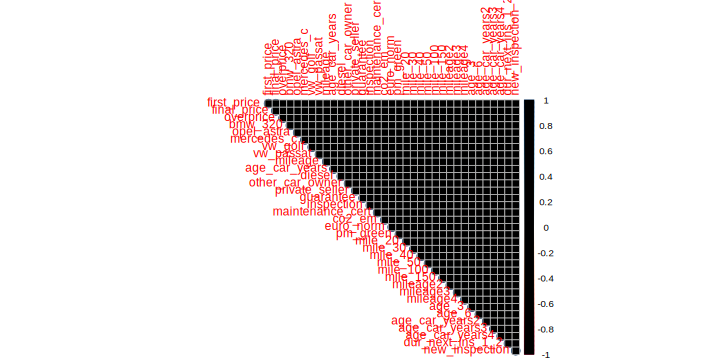

In [3]:
desc <- round(basicStats(data_raw),digits=2)
print(t(desc[c(7,14,3,4,1),]))
#kable(t(desc[c(7,14,3,4,1),]), "latex", booktabs = T)


corr = cor(data_raw)
corrplot(corr, type = "upper")

#png(height=1200, width=1200, file="correlataion.png")
#corrplot(corr, type = "upper")
#dev.off()

### Prepare Dataset

In [4]:
# Extracting and scaling continuous variables
scaled_baseline_covariates_cont <- df %>%
  dplyr::select(baseline_covariates_cont) %>%
  dplyr::mutate_all(scale)

scaled_lasso_covariates_cont <- df %>%
  dplyr::select(lasso_covariates_cont) %>%
  dplyr::mutate_all(scale)

# Extracting indicator variables
baseline_covariates_bin <- df %>%
  dplyr::select(baseline_covariates_bin)

lasso_covariates_bin <- df %>%
  dplyr::select(lasso_covariates_bin)

# Extracting outcome 
outcomes <- df %>% dplyr::select(outcomes)

# Setting up the data, renaming columns and discarding rows with NA (if any)
df <- bind_cols(outcomes, scaled_baseline_covariates_cont, baseline_covariates_bin, scaled_lasso_covariates_cont, lasso_covariates_bin) %>%
  na.omit()

### Take hold-outsample

In [5]:
df_part <- modelr::resample_partition(df, c(obs = 0.8, hold_out = 0.2))
df_obs <- as.data.frame(df_part$obs)
df_hold_out <- as.data.frame(df_part$hold_out)

# Outcomes
first_price_obs <- as.matrix(df_obs[,1])
final_price_obs <- as.matrix(df_obs[,2])
overprice_obs <- as.matrix(df_obs[,3])

first_price_hold_out <- as.matrix(df_hold_out[,1])
final_price_hold_out <- as.matrix(df_hold_out[,2])
overprice_hold_out <- as.matrix(df_hold_out[,3])

## Covariates
baseline_covariates_obs <- as.matrix(df_obs[,c(4:19)]) 
covariates_lasso_obs <- as.matrix(df_obs[,c(4:ncol(df))])

baseline_covariates_hold_out <- as.matrix(df_hold_out[,c(4:19)]) 
covariates_lasso_hold_out <- as.matrix(df_hold_out[,c(4:ncol(df))])   

### Tree Estimator

9 
9 


[1] -0.02003024

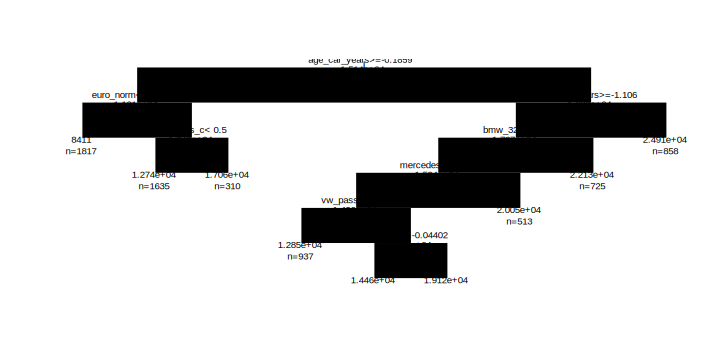

In [7]:
# Tree

tree_data_obs <-  data.frame(final_price_obs, baseline_covariates_obs)

empty <- as.matrix(final_price_hold_out)
empty[1,] <-NA
tree_data_hold_out <-  data.frame(rbind(final_price_obs,empty),rbind(baseline_covariates_obs, baseline_covariates_hold_out))

sumx <- paste(baseline_covariates, collapse = " + ")  # "X1 + X2 + X3 + ..." for substitution later
linear <- paste("final_price_obs",paste(sumx, sep=" + "), sep=" ~ ")
linear <- as.formula(linear)

linear.singletree_1 <- rpart(formula = linear, data = tree_data_obs , method = "anova", xval = 10,
                             y = TRUE, control = rpart.control(cp = 0.01, minbucket=300))
cp.vals_1 <- linear.singletree_1$cptable[ which.min(linear.singletree_1$cptable[, "xerror"]), "CP"]
treepruned.linearsingle_1 <- prune(linear.singletree_1, cp = cp.vals_1)
pred_tree_hold_out_1 <- as.matrix(predict(treepruned.linearsingle_1, newdata=tree_data_hold_out))
pred_tree_obs_1 <- pred_tree_hold_out_1[c(1:nrow(tree_data_obs)),]
r <-nrow(final_price_obs)+1
pred_tree_hold_out_1 <- pred_tree_hold_out_1[c(r:nrow(pred_tree_hold_out_1)),]

# Number of final leaves
op.index_1 <- which.min(linear.singletree_1$cptable[, "xerror"])
print(op.index_1)

# Crossvalidation MSE
plotcp(linear.singletree_1)

#png(filename= "cp_tree1.png", units="in", width=5, height=4, pointsize=12, res=72)
#plotcp(linear.singletree_1)
#dev.off()

# Tree structure
plot(treepruned.linearsingle_1, uniform=TRUE)
text(treepruned.linearsingle_1, use.n=TRUE, all=TRUE, cex=.8)

#png(filename= "full_tree1.png",units="in", width=9, height=9, pointsize=12,res=72)
#plot(treepruned.linearsingle_1, uniform=TRUE)
#text(treepruned.linearsingle_1, use.n=TRUE, all=TRUE, cex=.8)
#dev.off()

# In-sample RMSE
mse_obs_1 <- sqrt((final_price_obs - pred_tree_obs_1)^2)
mean(mse_obs_1)

# Out-of-sample RMSE
mse_hold_out_1 <- sqrt((final_price_hold_out - pred_tree_hold_out_1)^2)
mean(mse_hold_out_1)

mse_hold_out <- sqrt((final_price_hold_out - mean(final_price_hold_out))^2)
1-mean(mse_hold_out_1)/mean(mse_hold_out)
1-mean(mse_hold_out_1)/mean(mse_obs_1)

### Deep Tree Estimator

342 
342 


[1] -0.4135934

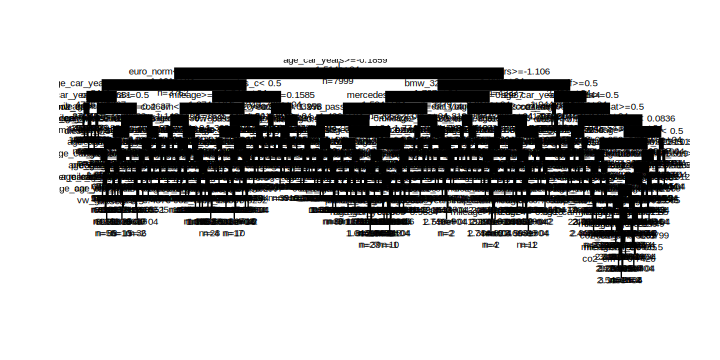

In [8]:
# Deep Tree
linear.singletree_2 <- rpart(formula = 'linear', data = tree_data_obs , method = "anova", xval = 10,
                             y = TRUE, control = rpart.control(cp = 0.00000001, minbucket=1))
cp.vals_2 <- linear.singletree_2$cptable[ which.min(linear.singletree_2$cptable[, "xerror"]), "CP"]
treepruned.linearsingle_2 <- prune(linear.singletree_2, cp = cp.vals_2)
pred_tree_hold_out_2 <- as.matrix(predict(treepruned.linearsingle_2, newdata=tree_data_hold_out))
pred_tree_obs_2 <- pred_tree_hold_out_2[c(1:nrow(tree_data_obs)),]
r <-nrow(final_price_obs)+1
pred_tree_hold_out_2 <- pred_tree_hold_out_2[c(r:nrow(pred_tree_hold_out_2)),]

# Number of final leaves
op.index_2 <- which.min(linear.singletree_2$cptable[, "xerror"])
print(op.index_2)

# Crossvalidation MSE
plotcp(linear.singletree_2)

#png(filename= "cp_tree2.png", units="in", width=5, height=4, pointsize=12, res=72)
#plotcp(linear.singletree_2)
#dev.off()

# Tree structure
plot(treepruned.linearsingle_2, uniform=TRUE)
text(treepruned.linearsingle_2, use.n=TRUE, all=TRUE, cex=.8)

#png(filename= "full_tree2.png",units="in", width=9, height=9, pointsize=12,res=72)
#plot(treepruned.linearsingle_2, uniform=TRUE)
#text(treepruned.linearsingle_2, use.n=TRUE, all=TRUE, cex=.8)
#dev.off()

# In-sample RMSE
mse_obs_2 <- sqrt((final_price_obs - pred_tree_obs_2)^2)
mean(mse_obs_2)
1- mean(mse_obs_2)/mean(mse_obs_1)

# Out-of-sample RMSE
mse_hold_out_2 <- sqrt((final_price_hold_out - pred_tree_hold_out_2)^2)
mean(mse_hold_out_2)
1- mean(mse_hold_out_2)/mean(mse_hold_out_1)
1-mean(mse_hold_out_2)/mean(mse_hold_out)
1-mean(mse_hold_out_2)/mean(mse_obs_2)

### Honest Deep Tree Estimator

108 
108 


[1] 0.719423

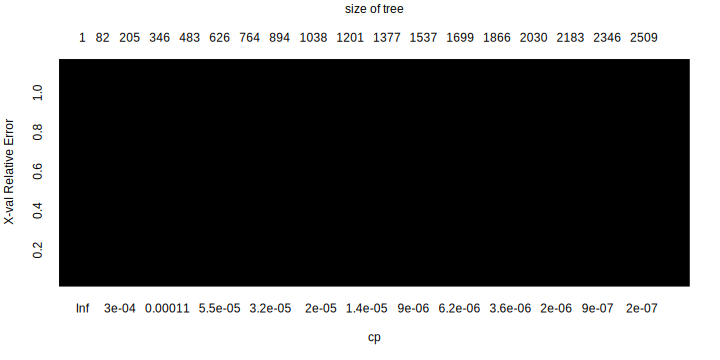

In [9]:
df_obs_part <- modelr::resample_partition(df_obs, c(train = 0.5, est = 0.5))
df_train <- as.data.frame(df_obs_part$train)
df_est <- as.data.frame(df_obs_part$est)

# Outcomes
final_price_train <- as.matrix(df_train[,2])
final_price_est <- as.matrix(df_est[,2])

## Covariates
baseline_covariates_train <- as.matrix(df_train[,c(4:19)]) 
baseline_covariates_est <- as.matrix(df_est[,c(4:19)]) 

tree_data_train <-  data.frame(final_price_train, baseline_covariates_train)

empty1 <- as.matrix(final_price_train)
empty1[1,] <-NA
empty2 <- as.matrix(final_price_hold_out)
empty2[1,] <-NA
tree_data_hold_out <-  data.frame(rbind(empty1,final_price_est,empty2),rbind(baseline_covariates_train,baseline_covariates_est, baseline_covariates_hold_out))


# Deep Tree
linear <- paste("final_price_train",paste(sumx, sep=" + "), sep=" ~ ")
linear <- as.formula(linear)
linear.singletree_3 <- rpart(formula = linear, data = tree_data_train , method = "anova", xval = 10,
                             y = TRUE, control = rpart.control(cp = 0.00000001, minbucket=1))
cp.vals_3 <- linear.singletree_3$cptable[ which.min(linear.singletree_3$cptable[, "xerror"]), "CP"]
treepruned.linearsingle_3 <- prune(linear.singletree_3, cp = cp.vals_3)
pred_tree_hold_out_3 <- as.matrix(predict(treepruned.linearsingle_3, newdata=tree_data_hold_out))
pred_tree_obs_3 <- pred_tree_hold_out_3[c(1:nrow(final_price_obs)),]
r <-nrow(final_price_obs)+1
pred_tree_hold_out_3 <- pred_tree_hold_out_3[c(r:nrow(pred_tree_hold_out_3)),]

# Number of final leaves
op.index_3 <- which.min(linear.singletree_3$cptable[, "xerror"])
print(op.index_3)

# Crossvalidation MSE
plotcp(linear.singletree_3)

# In-sample RMSE
mse_obs_3 <- sqrt((final_price_obs - pred_tree_obs_3)^2)
mean(mse_obs_3)
1-mean(mse_obs_3)/mean(mse_obs_2)

# Out-of-sample RMSE
mse_hold_out_3 <- sqrt((final_price_hold_out - pred_tree_hold_out_3)^2)
mean(mse_hold_out_3)
1-mean(mse_hold_out_3)/mean(mse_hold_out_2)
1-mean(mse_hold_out_3)/mean(mse_hold_out)
1-mean(mse_hold_out_3)/mean(mse_obs_3)

### Crossfitted Honest Deep Tree Estimator

In [10]:
tree_data_train1 <-  data.frame(final_price_train, baseline_covariates_train)
tree_data_train2 <-  data.frame(final_price_est, baseline_covariates_est)

empty1 <- as.matrix(final_price_train)
empty1[1,] <-NA
empty2 <- as.matrix(final_price_hold_out)
empty2[1,] <-NA
tree_data_hold_out1 <-  data.frame(rbind(empty1,final_price_est,empty2),rbind(baseline_covariates_train,baseline_covariates_est, baseline_covariates_hold_out))


empty1 <- as.matrix(final_price_est)
empty1[1,] <-NA
empty2 <- as.matrix(final_price_hold_out)
empty2[1,] <-NA
tree_data_hold_out2 <-  data.frame(rbind(final_price_train,empty1,empty2),rbind(baseline_covariates_train,baseline_covariates_est, baseline_covariates_hold_out))


# Deep Tree
linear <- paste("final_price_train",paste(sumx, sep=" + "), sep=" ~ ")
linear <- as.formula(linear)
linear.singletree_4 <- rpart(formula = linear, data = tree_data_train1 , method = "anova", xval = 10,
                             y = TRUE, control = rpart.control(cp = 0.00000001, minbucket=1))

cp.vals_4 <- linear.singletree_4$cptable[ which.min(linear.singletree_4$cptable[, "xerror"]), "CP"]
treepruned.linearsingle_4 <- prune(linear.singletree_4, cp = cp.vals_4)
pred_tree_hold_out_4 <- as.matrix(predict(treepruned.linearsingle_4, newdata=tree_data_hold_out))
pred_tree_obs_4 <- pred_tree_hold_out_4[c(1:nrow(final_price_obs)),]
r <-nrow(final_price_obs)+1
pred_tree_hold_out_4 <- pred_tree_hold_out_4[c(r:nrow(pred_tree_hold_out_4)),]

linear <- paste("final_price_est",paste(sumx, sep=" + "), sep=" ~ ")
linear <- as.formula(linear)
linear.singletree_5 <- rpart(formula = linear, data = tree_data_train2 , method = "anova", xval = 10,
                             y = TRUE, control = rpart.control(cp = 0.00000001, minbucket=1))

cp.vals_5 <- linear.singletree_5$cptable[ which.min(linear.singletree_5$cptable[, "xerror"]), "CP"]
treepruned.linearsingle_5 <- prune(linear.singletree_5, cp = cp.vals_5)
pred_tree_hold_out_5 <- as.matrix(predict(treepruned.linearsingle_5, newdata=tree_data_hold_out))
pred_tree_obs_5 <- pred_tree_hold_out_5[c(1:nrow(final_price_obs)),]
r <-nrow(final_price_obs)+1
pred_tree_hold_out_5 <- pred_tree_hold_out_5[c(r:nrow(pred_tree_hold_out_5)),]


# In-sample RMSE
mse_obs_4 <- sqrt((final_price_obs - 0.5*(pred_tree_obs_4 +pred_tree_obs_5) )^2)
mean(mse_obs_4)
1-mean(mse_obs_4)/mean(mse_obs_2)

# Out-of-sample RMSE
mse_hold_out_4 <- sqrt((final_price_hold_out - 0.5*(pred_tree_hold_out_4 +pred_tree_hold_out_5))^2)
mean(mse_hold_out_4)
1-mean(mse_hold_out_4)/mean(mse_hold_out_2)
1-mean(mse_hold_out_4)/mean(mse_hold_out)
1-mean(mse_hold_out_4)/mean(mse_obs_4)

[1] 0.7466107